In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

In [5]:
# Cargar el dataset de Caltech101 desde TFDS
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]', 'test[:90%]'],
    with_info=True,
    as_supervised=True,
    download=True
)

# Obtener el número de clases
num_classes = dataset_info.features['label'].num_classes

In [6]:
# Función para preprocesar las imágenes
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Preprocesar y preparar los datasets
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)


In [7]:
# Verificar la estructura del dataset
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

Image shape: (32, 224, 224, 3)
Label: tf.Tensor(
[101  66  60  59  91  50  91  38  66   8  92  25  85  20  70  75  96   9
  13  97  20  35  32   3   8  35  81  69   7  15 100  72], shape=(32,), dtype=int64)


In [8]:

# Cargar el modelo base
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)


In [9]:
# Función para extraer características
def extract_features(dataset):
    features = []
    labels = []
    images_list = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
        images_list.append(images.numpy())
    return features, labels, images_list

# Extraer características para los datasets
train_features, train_labels, train_images = extract_features(train_dataset)
test_features, test_labels, test_images = extract_features(test_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [10]:
# Aplanar los mapas de características
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])
train_images_flat = np.array([image for batch in train_images for image in batch])

# Guardar características y etiquetas
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels_flat)
np.save('train_images.npy', train_images_flat)

In [11]:
# Cargar características y etiquetas
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')
train_images_flat = np.load('train_images.npy')

In [12]:
# Ajustar el modelo NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

In [13]:
# Extraer características de una imagen de consulta
query_image, _ = next(iter(test_dataset.take(1)))
query_image = query_image[1]  # Obtener la imagen del lote
query_image = tf.expand_dims(query_image, axis=0)  # Añadir dimensión de lote
query_features = model.predict(query_image).flatten().reshape(1, -1)
query_image_display = query_image.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [14]:
# Encontrar los vecinos más cercanos
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [[1157 1485  502 1293 2120]]
Distances to nearest neighbors: [[ 84.58801642 115.21841358 117.64940984 124.65693342 137.93504401]]


(-0.5, 223.5, 223.5, -0.5)

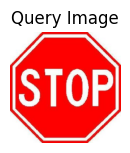

In [15]:
# Mostrar la imagen de consulta
plt.figure(figsize=(10, 6))
plt.subplot(1, 6, 1)
plt.imshow(query_image_display[0])
plt.title("Query Image")
plt.axis('off')

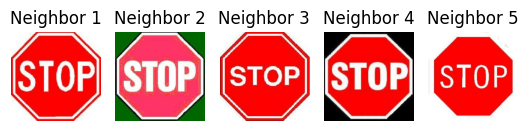

In [16]:
# Mostrar las imágenes de los vecinos más cercanos
for i, index in enumerate(indices[0]):
    plt.subplot(1, 6, i + 2)
    plt.imshow(train_images_flat[index])
    plt.title(f"Neighbor {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
import joblib

# Guardar el modelo NearestNeighbors
joblib.dump(nn_model, 'nearest_neighbors_model.pkl')


['nearest_neighbors_model.pkl']